In [ ]:
from google.colab import files
uploaded = files.upload()


Saving media prediction and its cost.csv to media prediction and its cost.csv


In [ ]:
import pandas as pd

# Đọc file CSV
df = pd.read_csv("media prediction and its cost.csv")
df.head()


,food_category,food_department,food_family,store_sales(in millions),store_cost(in millions),unit_sales(in millions),promotion_name,sales_country,marital_status,gender,...,grocery_sqft,frozen_sqft,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,media_type,cost
0,Breakfast Foods,Frozen Foods,Food,7.36,2.7232,4.0,Bag Stuffers,USA,M,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",126.62
1,Breakfast Foods,Frozen Foods,Food,5.52,2.5944,3.0,Cash Register Lottery,USA,M,M,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",59.86
2,Breakfast Foods,Frozen Foods,Food,3.68,1.3616,2.0,High Roller Savings,USA,S,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",84.16
3,Breakfast Foods,Frozen Foods,Food,3.68,1.1776,2.0,Cash Register Lottery,USA,M,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,In-Store Coupon,95.78
4,Breakfast Foods,Frozen Foods,Food,4.08,1.4280,3.0,Double Down Sale,USA,M,M,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,Radio,50.79


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [ ]:
# Đọc file CSV
df = pd.read_csv("media prediction and its cost.csv")
df.dropna(axis=1, how='all', inplace=True)
df.fillna(method='ffill', inplace=True)

# Kiểm tra cột văn bản
print("Các cột dạng văn bản:", df.select_dtypes(include='object').columns)


<ipython-input-8-dfe83a64e818>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Các cột dạng văn bản: Index(['food_category', 'food_department', 'food_family', 'promotion_name',
       'sales_country', 'marital_status', 'gender', 'education', 'member_card',
       'occupation', 'houseowner', 'avg. yearly_income', 'brand_name',
       'store_type', 'store_city', 'store_state', 'media_type'],
      dtype='object')


In [ ]:
text_col = 'media_type'
documents = df[text_col].astype(str).values


In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_sparse = vectorizer.fit_transform(documents)

print("Kích thước ma trận TF-IDF:", X_sparse.shape)


Kích thước ma trận TF-IDF: (60428, 15)


In [ ]:
y = np.random.randint(0, 2, size=X_sparse.shape[0])  # nhãn giả lập
selector = SelectKBest(score_func=chi2, k=100)
X_selected = selector.fit_transform(X_sparse, y)

selected_features = np.array(vectorizer.get_feature_names_out())[selector.get_support()]
print("Top 10 từ khóa được chọn:", selected_features[:10])


Top 10 từ khóa được chọn: ['attachment' 'bulk' 'cash' 'coupon' 'daily' 'handout' 'mail' 'paper'
 'product' 'radio']


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=100 is greater than n_features=15. All the features will be returned.
  warnings.warn(


In [ ]:
vt = VarianceThreshold(threshold=0.01)
X_high_variance = vt.fit_transform(X_selected.toarray())
print("Kích thước sau khi lọc phương sai thấp:", X_high_variance.shape)


Kích thước sau khi lọc phương sai thấp: (60428, 15)


In [ ]:
n_topics = 5
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_topics = lda_model.fit_transform(X_sparse)

def print_topics(model, feature_names, n_top_words=5):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Chủ đề #{topic_idx + 1}: {', '.join(top_words)}")

print("🔍 Các chủ đề rút ra từ media_type:")
print_topics(lda_model, vectorizer.get_feature_names_out())


🔍 Các chủ đề rút ra từ media_type:
Chủ đề #1: daily, street, handout, paper, radio
Chủ đề #2: tv, register, cash, handout, paper
Chủ đề #3: store, coupon, paper, daily, radio
Chủ đề #4: attachment, product, mail, bulk, paper
Chủ đề #5: radio, paper, sunday, daily, tv


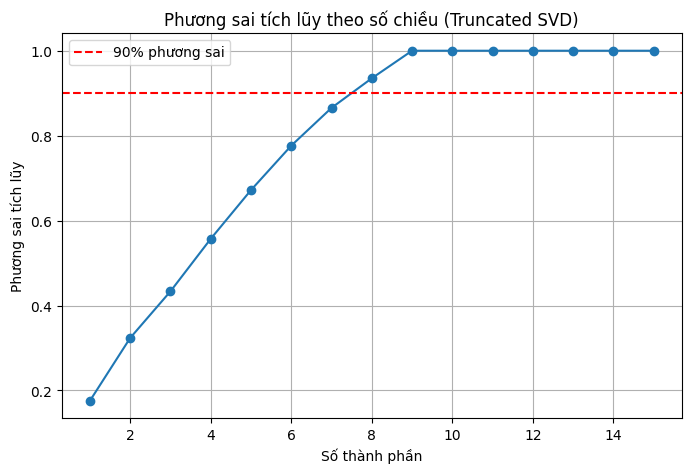

In [ ]:
svd = TruncatedSVD(n_components=15, random_state=42)
X_svd = svd.fit_transform(X_sparse)
explained = np.cumsum(svd.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
# Thay đổi phạm vi để khớp với số thành phần (15)
plt.plot(range(1, 16), explained, marker='o')
plt.title("Phương sai tích lũy theo số chiều (Truncated SVD)")
plt.xlabel("Số thành phần")
plt.ylabel("Phương sai tích lũy")
plt.grid(True)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% phương sai')
plt.legend()
plt.show()


In [2]:
import pandas as pd

df = pd.read_csv("media prediction and its cost.csv")
df.dropna(axis=1, how='all', inplace=True)
df.fillna(method='ffill', inplace=True)


FileNotFoundError: [Errno 2] No such file or directory: 'media prediction and its cost.csv'

In [3]:
from google.colab import files
uploaded = files.upload()

Saving media prediction and its cost.csv to media prediction and its cost.csv


In [4]:
import pandas as pd

# Đọc file CSV
df = pd.read_csv("media prediction and its cost.csv")
df.head()

,food_category,food_department,food_family,store_sales(in millions),store_cost(in millions),unit_sales(in millions),promotion_name,sales_country,marital_status,gender,...,grocery_sqft,frozen_sqft,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,media_type,cost
0,Breakfast Foods,Frozen Foods,Food,7.36,2.7232,4.0,Bag Stuffers,USA,M,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",126.62
1,Breakfast Foods,Frozen Foods,Food,5.52,2.5944,3.0,Cash Register Lottery,USA,M,M,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",59.86
2,Breakfast Foods,Frozen Foods,Food,3.68,1.3616,2.0,High Roller Savings,USA,S,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",84.16
3,Breakfast Foods,Frozen Foods,Food,3.68,1.1776,2.0,Cash Register Lottery,USA,M,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,In-Store Coupon,95.78
4,Breakfast Foods,Frozen Foods,Food,4.08,1.4280,3.0,Double Down Sale,USA,M,M,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,Radio,50.79


In [5]:
from sklearn.preprocessing import LabelEncoder

# Tạo nhãn từ cột media_type
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['media_type'].astype(str))

# In danh sách các nhãn đã mã hoá
print("Classes:", label_encoder.classes_)
print("y shape:", y.shape)

Classes: ['Bulk Mail' 'Cash Register Handout' 'Daily Paper' 'Daily Paper, Radio'
 'Daily Paper, Radio, TV' 'In-Store Coupon' 'Product Attachment' 'Radio'
 'Street Handout' 'Sunday Paper' 'Sunday Paper, Radio'
 'Sunday Paper, Radio, TV' 'TV']
y shape: (60428,)


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

documents = df['media_type'].astype(str).values
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_sparse = vectorizer.fit_transform(documents)

In [8]:
from sklearn.preprocessing import StandardScaler

# TF-IDF tạo ra sparse matrix → cần chuyển về dense để scale
X_dense = X_sparse.toarray()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dense)


In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


In [10]:
X_dense = X_sparse.toarray()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dense)


In [11]:
from sklearn.decomposition import PCA

# Giảm chiều còn 2 để dễ trực quan và phân loại
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("PCA shape:", X_pca.shape)


PCA shape: (60428, 2)


In [12]:
from sklearn.model_selection import train_test_split

# Tách tập train/test với 80/20
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (48342, 2)
Test size: (12086, 2)


In [14]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression với số vòng lặp cao hơn để đảm bảo hội tụ
clf = LogisticRegression(max_iter=1000, solver='lbfgs')  # hoặc solver='saga'
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [15]:
from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # dùng 'macro' hoặc 'weighted' tùy độ lệch lớp

print("🎯 Accuracy:", round(accuracy, 4))
print("🎯 F1 Score:", round(f1, 4))


🎯 Accuracy: 1.0
🎯 F1 Score: 1.0


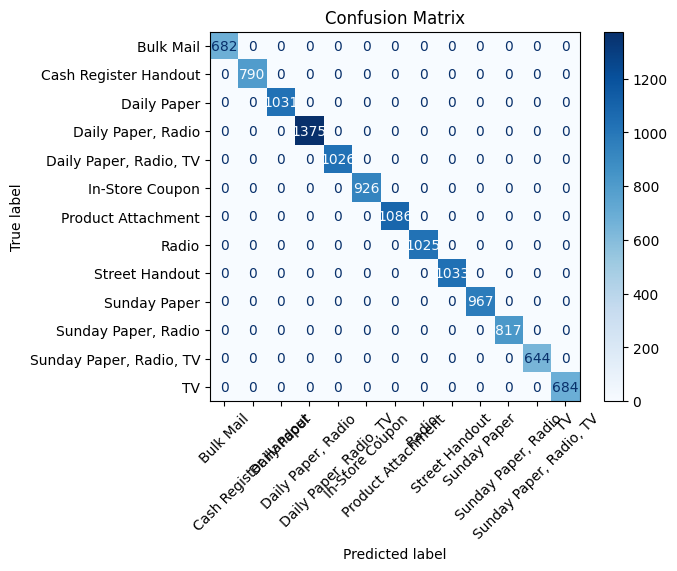

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# (giả sử y_test, y_pred và label_encoder đã được tạo từ trước)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
